In [2]:
import pandas as pd
import numpy as np
import pathlib
from tqdm.notebook import tqdm
import librosa
import awkward as ak
import matplotlib.pyplot as plt
from scipy.signal import decimate
from IPython.display import Audio

In [3]:
X_train = np.load("DATASETS/TimeSeriesTrimmed/RavdessTimeSeriesTrim_X_train.npy")
X_test = np.load("DATASETS/TimeSeries/RavdessTimeSeries_X_test.npy")
y_train = pd.read_csv('DATASETS/TimeSeries/RavdessTimeSeries_Y_train.csv')
y_test = pd.read_csv('DATASETS/TimeSeries/RavdessTimeSeries_Y_test.csv')

print(y_train.shape, y_test.shape)
print(X_train.shape, X_test.shape)

(1828, 9) (624, 9)
(1828, 243200) (624, 304304)


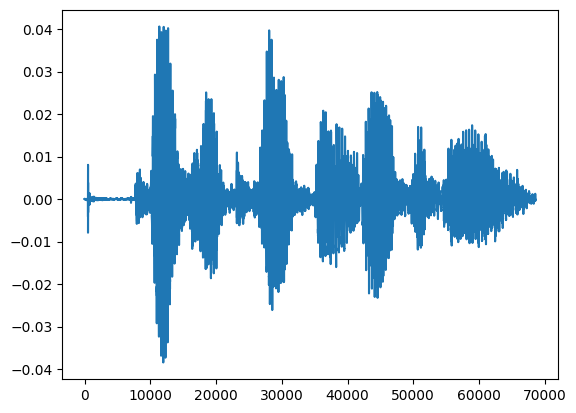

In [4]:
ts = X_train[0]
# Plot the selected time series
plt.plot(ts)
plt.show()

In [5]:
y_train["filename"][0]

'03-01-01-01-01-01-01.wav'

In [5]:
path = 'DATASETS/Audios/' + y_train["filename"][0]
ts, sr = librosa.load(path, sr=None)

In [6]:
sr

48000

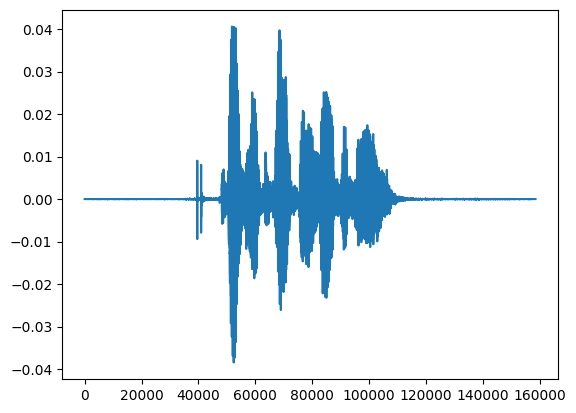

In [21]:
plt.plot(ts)
plt.show()

In [20]:
Audio(ts, rate=sr)

In [38]:
y_train["emotion"][42]

'fearful'

# Regularization

#### (offset translation, amplitude scaling, remove linear trend, remove noise...)

#### Carefully choose regularization techniques that can be used to preprocess the data and improve its suitability for various analyzes (motif/discord discovery, clustering and classification) but at the same time avoid information leaks.

    Taking into consideration the experiment conducted for audio collection and the nature of the dataset:
    
        + offset translation: by applying this operation, information on the tone of the voice may be lost 
          (however, can be useful to apply this operation to focus on other characteristics of the audio(?))
        + amplitude scaling:
        + linear trend:
        + noise:

### Smoothing (noise removing)

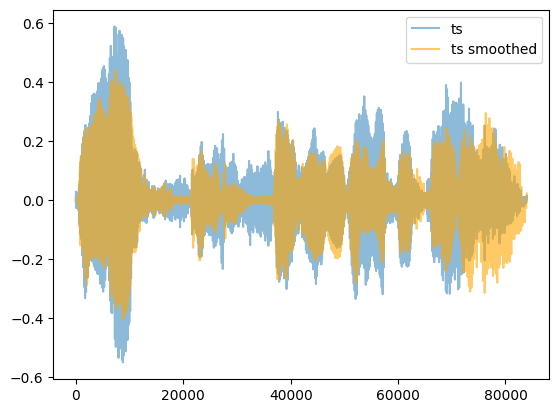

In [72]:
ts_pd = pd.Series(ts_trimmed)
w = 200
ts_smoothed = ((ts_pd - ts_pd.mean())/ts_pd.std()).rolling(window=w).mean()
plt.plot(ts_trimmed, alpha=0.5, label='ts')
plt.plot(ts_smoothed, color='orange', alpha=0.6, label='ts smoothed')
plt.legend()
plt.show()

### Trimming

     Notice that our audio is of only 3 seconds but the graph shows a longer time series.
     This is due to the nature of librosa library of having extra time duration space to accomodate noise. Trim
     source: https://www.kaggle.com/code/raksh710/audio-classification/notebook

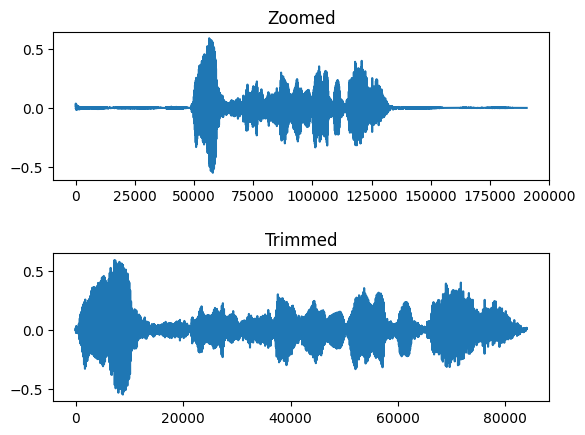

In [47]:
ts_trimmed, _ = librosa.effects.trim(ts, top_db=30)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=False)

ax1.plot(ts)#[49000:133500])
ax2.plot(ts_trimmed)

ax1.set_title('Zoomed')
ax2.set_title('Trimmed')

fig.subplots_adjust(hspace=0.5)
plt.show()

In [48]:
Audio(ts_trimmed, rate=sr)

# Approximation

In [49]:
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation
from tslearn.piecewise import OneD_SymbolicAggregateApproximation

from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesScalerMinMax
from sklearn.preprocessing import StandardScaler

### Scaling

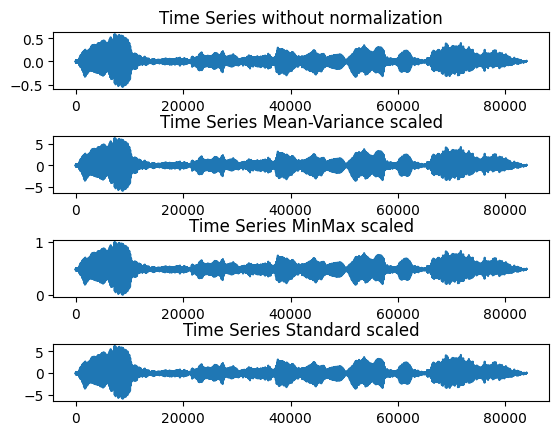

In [60]:
mvscaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)
ts_scaled = mvscaler.fit_transform(ts_trimmed.reshape(1, -1)).flatten()

minmaxscaler= TimeSeriesScalerMinMax()
ts_scaled_minmax = minmaxscaler.fit_transform(ts_trimmed.reshape(1, -1)).flatten()

stdscaler = StandardScaler()
ts_scaled_std = stdscaler.fit_transform(ts_trimmed.reshape(-1, 1)).flatten()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)

ax1.plot(ts_trimmed)
ax1.set_title("Time Series without normalization")
ax2.plot(ts_scaled)
ax2.set_title("Time Series Mean-Variance scaled")
ax3.plot(ts_scaled_minmax)
ax3.set_title("Time Series MinMax scaled")
ax4.plot(ts_scaled_std)
ax4.set_title("Time Series Standard scaled")

fig.subplots_adjust(hspace=0.8)

plt.show()

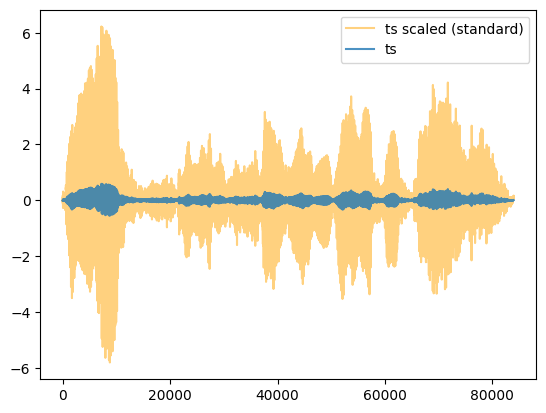

In [69]:
plt.plot(ts_scaled_std, color='orange', alpha=0.5, label='ts scaled (standard)')
plt.plot(ts_trimmed, alpha=0.8, label='ts')
plt.legend()
plt.show()

### PAA

In [73]:
n_paa_segments = 1000

paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)

ts_paa = paa.fit_transform(ts.reshape(1, -1))
paa_inv = paa.inverse_transform(ts_paa)

ts_trimmed_paa = paa.fit_transform(ts_trimmed.reshape(1, -1))
paa_inv_trimmed = paa.inverse_transform(ts_trimmed_paa)

C:\Users\andri\AppData\Roaming\Python\Python310\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
C:\Users\andri\AppData\Roaming\Python\Python310\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


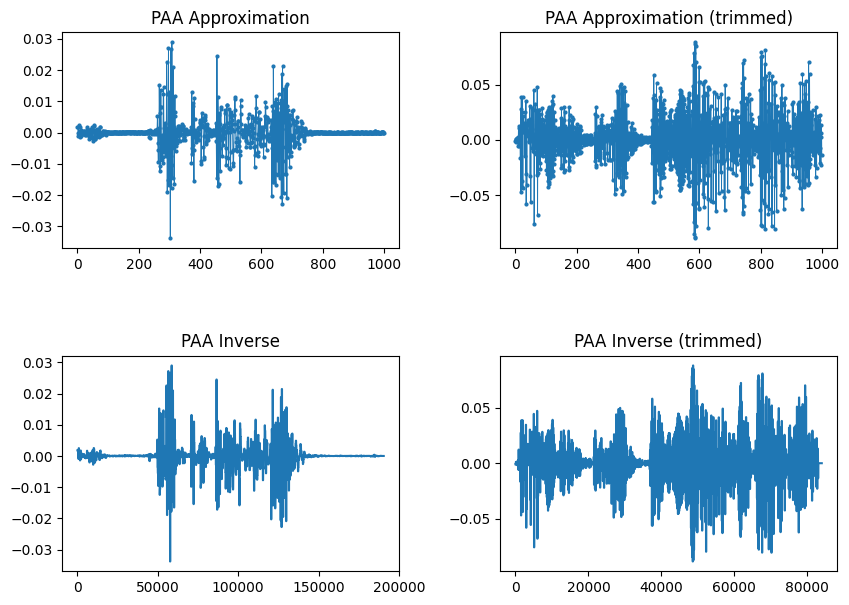

In [74]:
fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2, 2, sharex=False, figsize=(10,7))

ax1.plot(ts_paa.ravel(), marker='o', linewidth=0.7, markersize=2)
ax2.plot(paa_inv.ravel())

ax3.plot(ts_trimmed_paa.ravel(), marker='o', linewidth=0.7, markersize=2)
ax4.plot(paa_inv_trimmed.ravel())

ax1.set_title("PAA Approximation")
ax2.set_title("PAA Inverse")
ax3.set_title("PAA Approximation (trimmed)")
ax4.set_title("PAA Inverse (trimmed)")

fig.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

### SAX

In [79]:
n_sax_segments = 20

sax = SymbolicAggregateApproximation(n_segments=n_sax_segments, alphabet_size_avg=8)

ts_sax = sax.fit_transform(ts.reshape(1, -1))
sax_inv = sax.inverse_transform(ts_sax)

ts_trimmed_sax = sax.fit_transform(ts_trimmed.reshape(1, -1))
sax_inv_trimmed = sax.inverse_transform(ts_trimmed_sax)

C:\Users\andri\AppData\Roaming\Python\Python310\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
C:\Users\andri\AppData\Roaming\Python\Python310\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


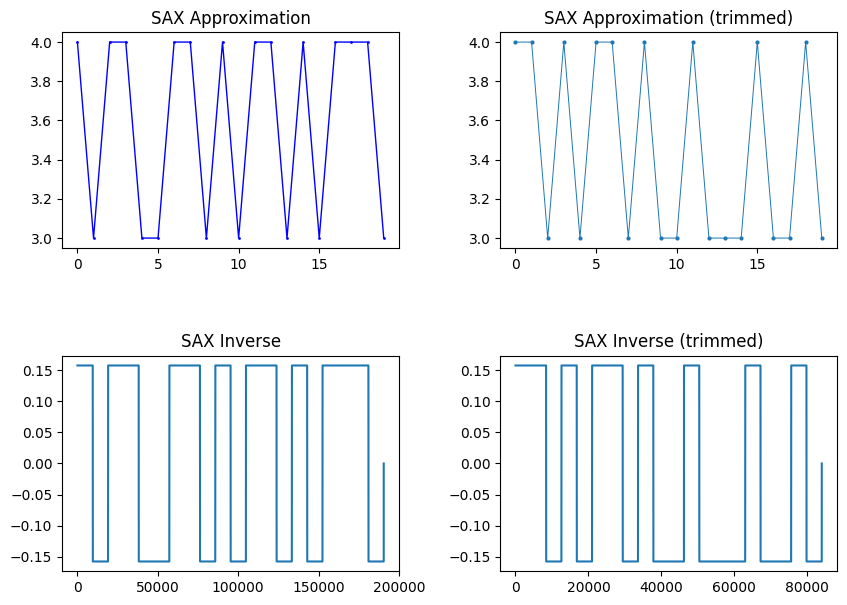

In [80]:
fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2, 2, sharex=False, figsize=(10,7))

ax1.plot(ts_sax.ravel(), 'b.-', linewidth=1, markersize=2)
ax2.plot(sax_inv.ravel())

ax3.plot(ts_trimmed_sax.ravel(), marker='o', linewidth=0.7, markersize=2)
ax4.plot(sax_inv_trimmed.ravel())

ax1.set_title("SAX Approximation")
ax2.set_title("SAX Inverse")
ax3.set_title("SAX Approximation (trimmed)")
ax4.set_title("SAX Inverse (trimmed)")

fig.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

## Experiments

In [252]:
from tslearn.metrics import dtw, dtw_path, cdist_dtw, subsequence_cost_matrix
from fastdtw import fastdtw
Y_train

,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex,filename
0,audio-only,speech,neutral,normal,Kids are talking by the door,1st,1,M,03-01-01-01-01-01-01.wav
1,audio-only,speech,neutral,normal,Kids are talking by the door,2nd,1,M,03-01-01-01-01-02-01.wav
2,audio-only,speech,neutral,normal,Dogs are sitting by the door,1st,1,M,03-01-01-01-02-01-01.wav
3,audio-only,speech,neutral,normal,Dogs are sitting by the door,2nd,1,M,03-01-01-01-02-02-01.wav
4,audio-only,speech,calm,normal,Kids are talking by the door,1st,1,M,03-01-02-01-01-01-01.wav
...,...,...,...,...,...,...,...,...,...
1823,audio-only,speech,surprised,normal,Dogs are sitting by the door,2nd,18,F,03-01-08-01-02-02-18.wav
1824,audio-only,speech,surprised,strong,Kids are talking by the door,1st,18,F,03-01-08-02-01-01-18.wav
1825,audio-only,speech,surprised,strong,Kids are talking by the door,2nd,18,F,03-01-08-02-01-02-18.wav
1826,audio-only,speech,surprised,strong,Dogs are sitting by the door,1st,18,F,03-01-08-02-02-01-18.wav


In [257]:
mask = (Y_train['emotion']=='disgust') & (Y_train['sex']=='F') & (Y_train["statement"]=='Kids are talking by the door') & (Y_train["emotional_intensity"]=='normal')& (Y_train["vocal_channel"]=='speech')

indices = Y_train.index[mask]
print(indices)

Int64Index([ 148,  149,  356,  357,  564,  565,  772,  773,  980,  981, 1188,
            1189, 1396, 1397, 1604, 1605, 1812, 1813],
           dtype='int64')


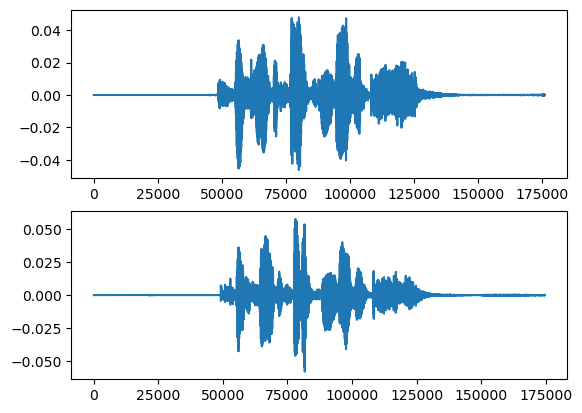

In [258]:
ts1, ts2 = X_train[148], X_train[149]
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(ts1)
ax2.plot(ts2)

In [259]:
n_paa_segments = 100

paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)

ts1_paa = paa.fit_transform(ts1.reshape(1, -1))
ts2_paa = paa.fit_transform(ts2.reshape(1, -1))

dist = fastdtw(ts1_paa, ts2_paa)
dist

C:\Users\linov\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
C:\Users\linov\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


(0.004956771957766821, [(0, 0)])